### Arquitectura UNet para la estimación de mapas de radio y clasificación de celdas, para escenarios de interiores

#### Cargue de librerías

In [1]:
import tensorflow as tf 
from tensorflow.keras import optimizers
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
import numpy as np
import os
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import time
import random

### Inicialización de algunos parámetros principales

In [2]:
n_classes = 3 # Cuando n_classes es igual a 1 no se puede especificar simulation = cells, ya que el sistema no realiza esta práctica, al asumirse que con
# 1 celda se cubre toda el área de funcionamiento.
simulation = 'cells'
porc_val = 0.2
epochs = 50
batch_size = 16
learning_rate = 1e-3
higth_img = 256 
width_img = 256
scenarios = 10
positions = 1000 # Se elige cuántas simulaciones se desean cargan de 1000 totales por escenario

# Algunas configuraciones para el optimizador
"""lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-2,
    decay_steps = 5000,
    decay_rate = 0.9)"""

dir_dataset_esc = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/Escenarios'
if n_classes == 3:
    dir_dataset_pos = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/3AP/Transmisores'
    dir_masks = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/3AP/Celdas'
    dir_maps = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/3AP/Mapas'
if n_classes == 2:
    dir_dataset_pos = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/2AP/Transmisores'
    dir_masks = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/2AP/Celdas'
    dir_maps = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/2AP/Mapas'
if n_classes == 1:
    dir_dataset_pos = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/1AP/Transmisores'
    dir_maps = 'C:/Users/GIIEE/Documents/johan/proyecto/DataSet/1AP/Mapas'

#### Funciones para definir la arquitectura UNet

In [3]:
################################################################
def block_1convolution(input_b1 = None, filters = None, kernel = None, train = True):
    conv1 = Conv2D(filters, kernel, padding = 'same', kernel_initializer='he_normal', trainable = train)(input_b1)
    batch_norm1 = BatchNormalization(trainable = train)(conv1)
    act1 = ReLU(trainable = train)(batch_norm1)
    
    return act1
################################################################
def block_2convolution(input_b2 = None, filters = None, kernel = None, train = True):
    conv1 = Conv2D(filters//2, kernel, padding = 'same', kernel_initializer='he_normal', trainable = train)(input_b2)
    batch_norm1 = BatchNormalization(trainable = train)(conv1)
    act1 = ReLU(trainable = train)(batch_norm1)
    
    conv2 = Conv2D(filters, kernel, padding = 'same', kernel_initializer='he_normal', trainable = train)(act1)
    batch_norm2 = BatchNormalization(trainable = train)(conv2)
    act2 = ReLU(trainable = train)(batch_norm2)
    
    return act2
###############################################################
def encoder(input_enc = None, filters = None, kernel = None, train = True):
    enc1 = block_2convolution(input_enc, filters, kernel, train = train)
    MaxPool1 = MaxPooling2D(strides = (2,2), trainable = train)(enc1)
    return enc1, MaxPool1
###############################################################
def decoder(input_dec = None, skip = None, filters = None, kernel = None, train = True):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding = 'same', trainable = train)(input_dec)
    Connect_Skip = Concatenate(trainable = train)([Upsample, skip])
    out = block_2convolution(Connect_Skip, filters, kernel, train = train)
    return out
###############################################################
def U_Net(n_classes = None, higth_img = None, width_img = None, channels_img = None, 
          simulation = ''):

    # Entrada
    input1 = Input((higth_img, width_img, channels_img))
    
    #256,256,profundidad
    skip1_1, encoder_1_1 = encoder(input1, filters = 6, kernel = 3) #128,128,profundidad
    skip2_1, encoder_2_1 = encoder(encoder_1_1, filters = 40, kernel = 3) #64,64,profundidad
    skip3_1, encoder_3_1 = encoder(encoder_2_1, filters = 50, kernel = 3) #32,32,profundidad
    skip4_1, encoder_4_1 = encoder(encoder_3_1, filters = 60, kernel = 3) #16,16,profundidad
    skip5_1, encoder_5_1 = encoder(encoder_4_1, filters = 100, kernel = 3) #8,8,profundidad
    skip6_1, encoder_6_1 = encoder(encoder_5_1, filters = 200, kernel = 3) #4,4,profundidad
    skip7_1, encoder_7_1 = encoder(encoder_6_1, filters = 300, kernel = 3) #2,2,profundidad
    skip8_1, encoder_8_1 = encoder(encoder_7_1, filters = 400, kernel = 3) #1,1,profundidad
    
    conv_block_1 = block_2convolution(encoder_8_1, filters = 600, kernel = 3) #1,1,profundidad
    
    decoder_1_1 = decoder(conv_block_1, skip8_1, filters = 400, kernel = 3) #2,2,profundidad
    decoder_2_1 = decoder(decoder_1_1, skip7_1, filters = 300, kernel = 3) #4,4,profundidad
    decoder_3_1 = decoder(decoder_2_1, skip6_1, filters = 200, kernel = 3) #8,8,profundidad
    decoder_4_1 = decoder(decoder_3_1, skip5_1, filters = 100, kernel = 3) #16,16,profundidad
    decoder_5_1 = decoder(decoder_4_1, skip4_1, filters = 60, kernel = 3) #32,32,profundidad
    decoder_6_1 = decoder(decoder_5_1, skip3_1, filters = 50, kernel = 3) #64,64,profundidad
    decoder_7_1 = decoder(decoder_6_1, skip2_1, filters = 40, kernel = 3) #128,128,profundidad       
    decoder_8_1 = decoder(decoder_7_1, skip1_1, filters = 20, kernel = 3) #256,256,profundidad
    
    conc1_1 = Concatenate()([decoder_8_1, input1])
    
    aditional_ = block_1convolution(conc1_1, filters = 20, kernel = 3) #256,256,profundidad
  
    conc2_1 = Concatenate()([aditional_, input1])
    
    if simulation == 'maps':
        out_1 = Conv2D(1, 1, padding = 'same', activation = 'relu', kernel_initializer='he_normal')(conc2_1)
    if simulation == 'cells':
        out_1 = Conv2D(n_classes, 1, padding = 'same', activation = 'softmax', kernel_initializer='he_normal')(conc2_1)
    
    model = Model(input1, out_1)
    
    return model
###############################################################

#### Visualización de la Arquitectura

In [4]:
if simulation == 'cells':
    channels_img = n_classes + 2
if simulation == 'maps':
    channels_img = n_classes + 1

model = U_Net(n_classes = n_classes, channels_img = channels_img, simulation = simulation)

model.summary()

for l in model.layers:
    print(l.name, l.trainable)

tf.keras.utils.plot_model(model, 'C:/Users/GIIEE/Documents/johan/proyecto/modelos/model.png', 
                          show_shapes=False, show_layer_names=True, 
                          rankdir='TB', expand_nested=False, dpi=110)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 111         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 12          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, None, None, 3 0           batch_normalization[0][0]        
_____________

#### Cargue de los datos

In [5]:
def data(simulation = '', n_classes = None, dir_dataset_pos = '', dir_masks = '', dir_maps = '',
        dir_dataset_esc = '', scenarios = None, positions = None):

    maps_inds = np.arange(1, (scenarios * positions) + 1, 1, dtype = np.int16) 
    np.random.seed(42) # Semilla para tener siempre los numeros aleatorios
    np.random.shuffle(maps_inds)

    train_images = []

    train_masks = [] 

    for idx in tqdm(maps_inds):
        idxr = np.floor((idx - 1)/positions).astype(int)
        idxc = idx - (idxr * positions)
        dataset_map_ind = idxr + 1

        name1 = str(dataset_map_ind) + ".png"
        name0 = str(dataset_map_ind) + "_" + str(idxc) + ".png"
        name2 = str(dataset_map_ind) + "_" + str(idxc) + ".png"
        
        if n_classes > 1:
            name2 = str(dataset_map_ind) + "_" + str(idxc) + "_" + '1' + ".png"
            name3 = str(dataset_map_ind) + "_" + str(idxc) + "_" + '2' + ".png"
            
        if n_classes > 2:
            name4 = str(dataset_map_ind) + "_" + str(idxc) + "_" + '3' + ".png"

        img_name_buildings = os.path.join(dir_dataset_esc, name1)
        image_buildings = np.asarray(io.imread(img_name_buildings))/255

        img_name_Tx1 = os.path.join(dir_dataset_pos, name2)
        image_Tx1 = np.asarray(io.imread(img_name_Tx1))/255

        if n_classes > 1:
            img_name_Tx2 = os.path.join(dir_dataset_pos, name3)
            image_Tx2 = np.asarray(io.imread(img_name_Tx2))/255

        if n_classes > 2:
            img_name_Tx3 = os.path.join(dir_dataset_pos, name4)
            image_Tx3 = np.asarray(io.imread(img_name_Tx3))/255

        if n_classes == 1:
            img = np.stack([image_buildings, image_Tx1], axis = 2)  
            train_images.append(img)    
            
        if n_classes == 2 and simulation == 'maps':
            img = np.stack([image_buildings, image_Tx1, image_Tx2], axis = 2)  
            train_images.append(img)
            
        if n_classes == 2 and simulation == 'cells':
            maps1 = os.path.join(dir_maps, name0)
            maps1 = np.asarray(io.imread(maps1))/255
            img = np.stack([image_buildings, image_Tx1, image_Tx2, maps1], axis = 2)  
            train_images.append(img)
            
        if n_classes == 3 and simulation == 'maps':
            img = np.stack([image_buildings, image_Tx1, image_Tx2, image_Tx3], axis = 2)  
            train_images.append(img) 
            
        if n_classes == 3 and simulation == 'cells':
            maps1 = os.path.join(dir_maps, name0)
            maps1 = np.asarray(io.imread(maps1))/255
            img = np.stack([image_buildings, image_Tx1, image_Tx2, image_Tx3, maps1], axis = 2)  
            train_images.append(img)

        if simulation == 'maps':    
            img_name_out = os.path.join(dir_maps, name0)  
            image_out = np.asarray(io.imread(img_name_out))/255
            train_masks.append(image_out)
        
        if simulation == 'cells' and n_classes != 1:    
            img_name_out = os.path.join(dir_masks, name0)  
            image_out = np.asarray(io.imread(img_name_out))
            train_masks.append(image_out)

    train_images = np.array(train_images)
    train_masks = np.array(train_masks)

    if simulation == 'maps': 
        train_masks_input = np.expand_dims(train_masks, axis=3)
        
    if simulation == 'cells': 
        labelencoder = LabelEncoder()
        n, h, w = train_masks.shape
        train_masks_reshaped = train_masks.reshape(-1,1)
        train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
        train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
        train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
    
    return train_images, train_masks_input
    
if n_classes == 1:   
    train_images, train_masks_input = data(simulation = simulation, n_classes = n_classes, 
                                        dir_dataset_pos = dir_dataset_pos, 
                                        dir_maps = dir_maps, dir_dataset_esc = dir_dataset_esc, 
                                        scenarios = scenarios, positions = positions)
else:
    train_images, train_masks_input = data(simulation = simulation, n_classes = n_classes, 
                                       dir_dataset_pos = dir_dataset_pos, dir_masks = dir_masks, 
                                       dir_maps = dir_maps, dir_dataset_esc = dir_dataset_esc, 
                                       scenarios = scenarios, positions = positions)

100%|██████████| 10000/10000 [00:39<00:00, 253.53it/s]


In [6]:
print(train_images.shape)
print(train_masks_input.shape)

(10000, 256, 256, 4)
(10000, 256, 256, 1)


#### Separación de los datos en entrenamiento y validación

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks_input, 
                                                  test_size = porc_val, random_state = 0)

#### Visualización de algunos datos

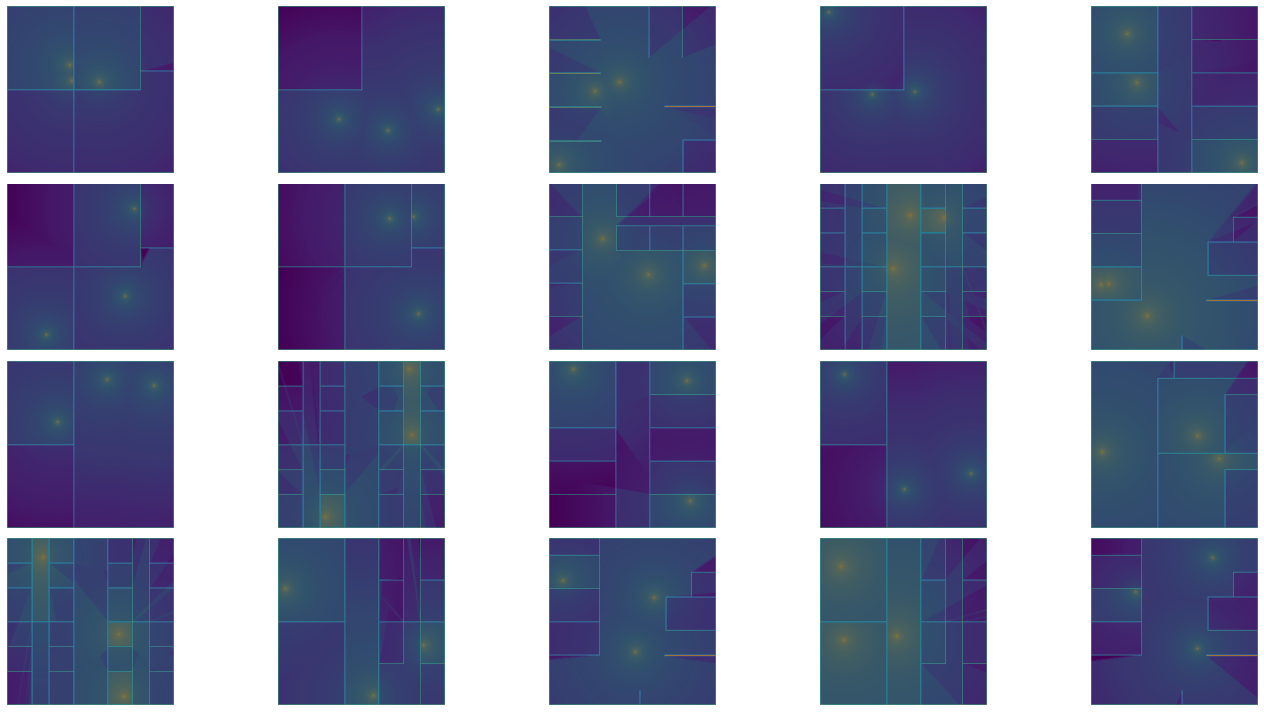

In [8]:
grapics = 20
imgs = X_train[:grapics,...]
masks = y_train[:grapics,...]
def plot_data(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(grapics):
        plt.subplot(4, 5, i+1)
        img=imgs[i,...]
        mask = masks[i, ...]
        plt.imshow(img[:,:,0])
        plt.imshow(mask[:,:,0], alpha=0.5)
        #print(np.unique(mask[:,:,0]))
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_data(imgs, masks)

#### Adecuación de la salida de las celdas en one-hot (si se requiere) y entrenamiento del modelo

In [9]:
optimizer = optimizers.Adam(learning_rate = learning_rate)

if simulation == 'cells':
    model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
if simulation == 'maps':
    model.compile(optimizer = optimizer, loss='mean_squared_error')

def training(model, simulation = '', n_classes = None, y_train = [], y_val = [], 
             epochs = None, batch_size = None):
    
    if simulation == 'cells':
        print('Valores únicos de clases: ', np.unique(y_train)) 
        
        y_train_cat = to_categorical(y_train, num_classes = n_classes)

        y_val_cat = to_categorical(y_val, num_classes = n_classes)
        
        callbacks = [keras.callbacks.ModelCheckpoint('C:/Users/GIIEE/Documents/johan/proyecto/modelos/indoor_' + 
                                                     simulation + '_' + str(n_classes) + '.h5', 
                                                     save_best_only = True)]

        history = model.fit(X_train, y_train_cat, 
                            batch_size = batch_size, 
                            verbose = 1, 
                            epochs = epochs, 
                            validation_data = (X_val, y_val_cat), 
                            callbacks = callbacks,
                            shuffle = False)
        
    if simulation == 'maps':
        callbacks = [keras.callbacks.ModelCheckpoint('C:/Users/GIIEE/Documents/johan/proyecto/modelos/indoor_' + 
                                                     simulation + '_' + str(n_classes) + '.h5', 
                                                     save_best_only = True)]

        history = model.fit(X_train, y_train, 
                            batch_size = batch_size, 
                            verbose = 1, 
                            epochs = epochs, 
                            validation_data = (X_val, y_val), 
                            callbacks = callbacks,
                            shuffle = False)
    
    return history
        
    ###############################################################################    
    
# Cambiar de acuerdo al problema *******************************************************
history = training(model = model, simulation = simulation, n_classes = n_classes, 
                   y_train = y_train, y_val = y_val, epochs = epochs, batch_size = batch_size
                   )

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 122s 15ms/sample - loss: 0.0196 - val_loss: 0.0203
Epoch 2/50
8000/8000 [==============================] - 91s 11ms/sample - loss: 0.0043 - val_loss: 0.0042
Epoch 3/50
8000/8000 [==============================] - 92s 12ms/sample - loss: 0.0029 - val_loss: 0.0030
Epoch 4/50
8000/8000 [==============================] - 94s 12ms/sample - loss: 0.0026 - val_loss: 0.0028
Epoch 5/50
8000/8000 [==============================] - 92s 12ms/sample - loss: 0.0024 - val_loss: 0.0026
Epoch 6/50
8000/8000 [==============================] - 92s 11ms/sample - loss: 0.0022 - val_loss: 0.0025
Epoch 7/50
8000/8000 [==============================] - 92s 11ms/sample - loss: 0.0021 - val_loss: 0.0024
Epoch 8/50
8000/8000 [==============================] - 91s 11ms/sample - loss: 0.0020 - val_loss: 0.0024
Epoch 9/50
8000/8000 [==============================] - 92s 12ms/sample - loss: 0.0020 - val_loss: 0.00

#### Visualización de los datos de entrenamiento

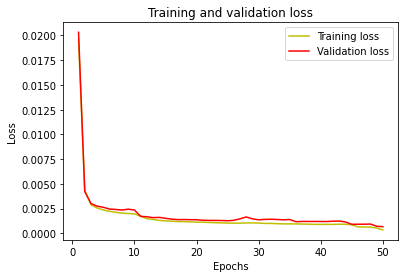

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('C:/Users/GIIEE/Documents/johan/proyecto/modelos/Loss_' + simulation + '_' + str(n_classes) + '.jpg')
plt.legend()
plt.show()

if simulation == 'cells':
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.plot(epochs, acc, 'y', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('C:/Users/GIIEE/Documents/johan/proyecto/modelos/acc_' + simulation + '_' + str(n_classes) + '.png')
    plt.legend()
    plt.show()
    

#### Predicción de algunos datos

El tiempo ejecutado para el cálculo es de: 0.048049211502075195 segundos
(256, 256, 4)
(1, 256, 256, 4)
(1, 256, 256, 1)
(256, 256, 1)


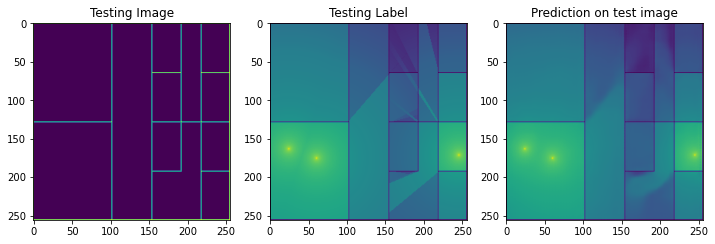

In [12]:
# Se cargan los pesos del modelo guardado
model.load_weights('C:/Users/GIIEE/Documents/johan/proyecto/modelos/indoor_' + simulation + '_' + str(n_classes) + '.h5')  

test_img_number = random.randint(0, len(X_val))
test_img = X_val[test_img_number]
ground_truth = y_val[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
inicio = time.time()
prediction = model.predict(test_img_input)
fin = time.time()
print(f'El tiempo ejecutado para el cálculo es de: {fin-inicio} segundos') 

print(test_img.shape)
print(test_img_input.shape)
print(prediction.shape)
print(ground_truth.shape)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
if simulation == 'cells':
    predicted_img = np.argmax(prediction, axis=3)[0,:,:]
    plt.imshow(predicted_img)
if simulation == 'maps':
    plt.imshow(prediction[0,:,:,0])
plt.show()